### 분석에 필요한 패키지 Import

In [56]:
# 다음 코드의 주석을 해제하고 패키지를 설치해주세요.
# !pip install xgboost lightgbm catboost scikit-learn --quiet

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

SEED = 42 # random state 통일

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (
    VotingClassifier,
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, StackingClassifier
)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

### 데이터 로드

In [59]:
# df라는 변수에 'Employee.csv' 파일을 읽어와 저장합니다.
df = pd.read_csv('Employee.csv')

In [60]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [61]:
target = 'LeaveOrNot'

In [62]:
X = df.drop(target, axis=1) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

### 데이터 전처리

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 290.9+ KB


In [64]:
X.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,Bachelors,2017,Bangalore,3,34,Male,No,0
1,Bachelors,2013,Pune,1,28,Female,No,3
2,Bachelors,2014,New Delhi,3,38,Female,No,2
3,Masters,2016,Bangalore,3,27,Male,No,5
4,Masters,2017,Pune,3,24,Male,Yes,2


In [65]:
# 범주형 변수 전처리
# 일괄적으로 인코딩을 진행하겠습니다.

cat_cols = [
    'Education',
    'City',
    'Gender',
    'EverBenched'
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.fit_transform(X[col].astype(str))

In [66]:
X.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,0,2017,0,3,34,1,0,0
1,0,2013,2,1,28,0,0,3
2,0,2014,1,3,38,0,0,2
3,1,2016,0,3,27,1,0,5
4,1,2017,2,3,24,1,1,2


In [67]:
# 스케일링

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 훈련용 / 테스트용 데이터 분할

In [68]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y, 
    random_state=SEED
)

In [69]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3489, 8)
(3489,)
(1164, 8)
(1164,)


## 모델링

주어진 데이터셋에 대해 단일 모델과 앙상블 기법을 각각 적용해보고 결과를 비교해봅시다.

### 단일 모델 적용

앙상블 기법을 적용하기 전에, 이전에 배웠던 단일 분류 모델들을 적용해봅시다!

(분류 기초 세션 복습 🤓)

#### 1. Logistic Regression

In [70]:
# 모델을 불러와 훈련시킵니다.
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [71]:
# 모델을 통해 예측을 수행합니다.
y_lr_pred = lr.predict(X_test)

In [72]:
# 계산된 예측값에 대해 정확도를 계산합니다.
lr_accuracy = accuracy_score(y_test, y_lr_pred)
lr_report = classification_report(y_test, y_lr_pred)

print(f"Accuracy score : {lr_accuracy}")
print(f"Report :\n{lr_report}")

Accuracy score : 0.7242268041237113
Report :
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       775
           1       0.64      0.40      0.49       389

    accuracy                           0.72      1164
   macro avg       0.69      0.64      0.65      1164
weighted avg       0.71      0.72      0.70      1164



#### 2. 의사결정나무

In [73]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [74]:
y_tree_pred = tree.predict(X_test)

In [75]:
tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_report = classification_report(y_test, y_tree_pred)

print(f"Accuracy score : {tree_accuracy}")
print(f"Report :\n{tree_report}")

Accuracy score : 0.8359106529209622
Report :
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       775
           1       0.78      0.71      0.74       389

    accuracy                           0.84      1164
   macro avg       0.82      0.81      0.81      1164
weighted avg       0.83      0.84      0.83      1164



#### 3. SVM

In [76]:
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [77]:
y_svm_pred = svm.predict(X_test)

In [78]:
svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_report = classification_report(y_test, y_svm_pred)

print(f"Accuracy score : {svm_accuracy}")
print(f"Report :\n{svm_report}")

Accuracy score : 0.8548109965635738
Report :
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       775
           1       0.91      0.63      0.74       389

    accuracy                           0.85      1164
   macro avg       0.87      0.80      0.82      1164
weighted avg       0.86      0.85      0.85      1164



#### 4. kNN

In [79]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [80]:
y_knn_pred = knn.predict(X_test)

In [81]:
knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_report = classification_report(y_test, y_knn_pred)

print(f"Accuracy score : {knn_accuracy}")
print(f"Report :\n{knn_report}")

Accuracy score : 0.8298969072164949
Report :
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       775
           1       0.81      0.64      0.72       389

    accuracy                           0.83      1164
   macro avg       0.82      0.78      0.80      1164
weighted avg       0.83      0.83      0.82      1164



#### 네 가지 단일 모델의 결과 비교

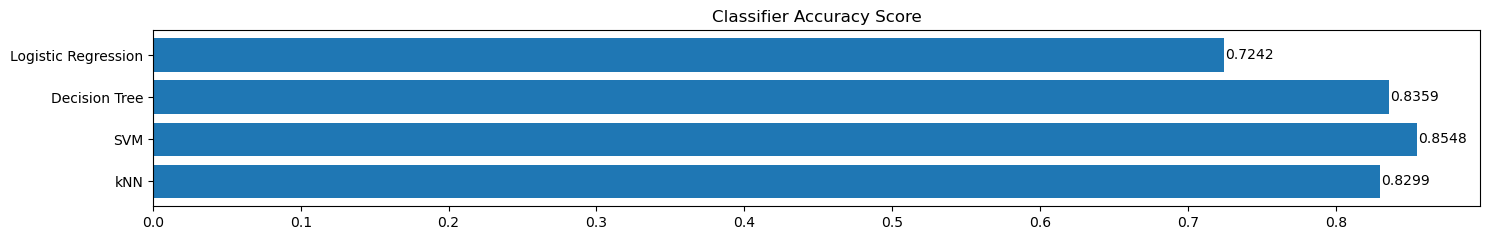

In [82]:
model_name = ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
accuracy_scores = [lr_accuracy, tree_accuracy, svm_accuracy, knn_accuracy]

plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 앙상블 (Ensemble)

### 1. Voting

`VotingClassifier`

- **estimators**: 사용할 기본 분류기 리스트 (이름, 모델) 형태로 지정
- **voting**: 'hard' 또는 'soft' (기본값: 'hard')
- **weights**: 각 분류기별 가중치
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [83]:
# estimators 인자로 들어갈 분류기 리스트를 지정합니다.
models = [
    ('lr', LogisticRegression(random_state=SEED)), 
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

In [84]:
# 모델 생성
# estimators는 models로, voting은 'hard'로 설정합니다.
voting_clf = VotingClassifier(
    estimators=models, 
    voting='hard'
)

# 모델 훈련
voting_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_voting_pred = voting_clf.predict(X_test)

# 정확도 출력
print(f"Voting Accuracy: {accuracy_score(y_test, y_voting_pred):.4f}")

Voting Accuracy: 0.8505


### 2. Bagging

`RandomForestClassifier`

- **n_estimators**: 트리 개수
- **max_depth**: 트리 최대 깊이
- **max_features**: 노드 분할 시 고려할 특성 수
- **min_samples_split**: 노드 분할에 필요한 최소 샘플 수
- **bootstrap**: 부트스트랩 여부 (기본값: True)

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [85]:
# 모델 생성
rf_clf = RandomForestClassifier(random_state=SEED)

# 모델 훈련
rf_clf.fit(X_train, y_train) 

# 테스트 데이터에 대한 예측 수행
y_rf_pred = rf_clf.predict(X_test)

# 정확도 출력
print(f"Bagging (Random Forest) Accuracy: {accuracy_score(y_test, y_rf_pred):.4f}")

Bagging (Random Forest) Accuracy: 0.8531


### 3. Boosting

#### 3.1 AdaBoost

`AdaBoostClassifier`

- **estimator**: 기본 약한 학습기
- **n_estimators**: 학습기 개수
- **learning_rate**: 학습률

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [86]:
# 모델 생성
adaboost = AdaBoostClassifier(random_state=SEED)

# 모델 훈련
adaboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_ada_pred = adaboost.predict(X_test)

# 정확도 출력
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_ada_pred):.4f}")

AdaBoost Accuracy: 0.8230


#### 3.2 GBM

`GradientBoostingClassifier`

- **n_estimators**: 부스팅 단계 수
- **learning_rate**: 각 단계의 기여도
- **max_depth**: 개별 트리의 최대 깊이
- **subsample**: 학습 데이터 샘플 비율
- **min_samples_split**: 노드 분할 최소 샘플 수
- **loss**: 손실 함수 ('log_loss', 'exponential')

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [87]:
# 모델 생성
gbm = GradientBoostingClassifier(random_state=SEED)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.8660


#### 3.3 XGBoost

`XGBClassifier`

- **n_estimators**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **max_depth**: 트리 깊이
- **subsample**: 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **gamma**: 분할 최소 손실 감소
- **objective**: 목적 함수 ('multi:softprob', 'binary:logistic' 등)
- **eval_metric**: 평가 지표 ('mlogloss', 'logloss', 'error' 등)

[Docs](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

In [88]:
# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED)

# 모델 훈련
xgboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred):.4f}")

XGBoost Accuracy: 0.8608


#### 3.4 LightGBM

`LGBMClassifier`

- **n_estimators**: 트리 개수
- **learning_rate**: 학습률
- **max_depth**: 최대 깊이 (기본: -1 → 제한 없음)
- **num_leaves**: 리프 노드 수
- **subsample**: 데이터 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **min_child_samples**: 리프 노드의 최소 샘플 수
- **objective**: 'binary', 'multiclass' 등

[Docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [89]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(random_state=SEED, verbose=-1)

# 모델 훈련
lgbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.predict(X_test)

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):.4f}")

LightGBM Accuracy: 0.8582


#### 3.5 CatBoost

`CatBoostClassifier`

- **iterations**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **depth**: 트리 깊이
- **l2_leaf_reg**: L2 정규화 계수
- **loss_function**: 손실 함수 (예: 'Logloss', 'MultiClass')
- **random_state**: 랜덤 시드
- **verbose**: 출력 제어 (0: 진행 메시지 표시하지 않음, 100: 진행률 표시)

[Docs](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

In [90]:
# 모델 생성
cb = CatBoostClassifier(random_state=SEED, depth=10, verbose=0)

# 모델 훈련
cb.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_cb_pred = cb.predict(X_test)

# 정확도 출력
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_cb_pred):.4f}")

CatBoost Accuracy: 0.8634


### 4. Stacking

`StackingClassifier`

- **estimators**: 기본 모델 목록 (이름, 모델) 쌍의 리스트
- **final_estimator**: 최종 분류기 (기본값: LogisticRegression)
- **cv**: 교차 검증 폴드 수 (기본값: 5)
- **passthrough**: 원본 특성을 메타 모델에 전달 여부 (기본값: False)
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [91]:
base_learners = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(random_state=SEED), # 최종 분류기를 LogisticRegression(random_state=SEED) 로 지정해주세요
    cv=5
)

# 모델 훈련
stack_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stk_pred = stack_clf.predict(X_test)

# 정확도 출력
print(f"Stacking Accuracy: {accuracy_score(y_test, y_stk_pred):.4f}")

Stacking Accuracy: 0.8557


## [과제] 모델 성능을 높여봅시다!

이제 직접 다른 전처리 기법, 피쳐 엔지니어링, 앙상블 기법, 추가 하이퍼파라미터 튜닝 등등.. 을 수행해서 더 높은 정확도를 가지는 모델을 만들어보세요.\
다양한 방법을 수행해보고, 비교한 후 결과를 정리해서 마크다운으로 남겨주시면 되겠습니다! 이때 각 단계별로 어떤 방법을 수행했는지에 대한 설명을 꼭 달아주세요.

- 정확도는 소수점 자릿수 제한 없이 모두 출력합니다.

# 1. EDA
데이터에 대해 알아보기 위해 각 칼럼별 고윳값, 각 칼럼과 target의 통계적 유의성 등을 찍어보았습니다.

In [92]:
data = df.copy()
data

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


## 1-1. 각 칼럼의 고유 값 확인

In [93]:
data['Education'].unique() # 학사, 석사, 박사

array(['Bachelors', 'Masters', 'PHD'], dtype=object)

In [94]:
data['JoiningYear'].unique() #2012년 ~ 2018년 (7년)

array([2017, 2013, 2014, 2016, 2015, 2012, 2018])

In [95]:
data['City'].unique() # 도시 3개

array(['Bangalore', 'Pune', 'New Delhi'], dtype=object)

In [96]:
data['PaymentTier'].unique() # 지급 티어 3단계

array([3, 1, 2])

In [97]:
data['Age'].unique() # 나이 22 ~ 41

array([34, 28, 38, 27, 24, 22, 23, 37, 32, 39, 29, 30, 36, 31, 25, 26, 40,
       35, 33, 41])

In [98]:
data['Gender'].unique() # 성별

array(['Male', 'Female'], dtype=object)

In [99]:
data['EverBenched'].unique() # 발령 대기 받은 적이 있는지 여부

array(['No', 'Yes'], dtype=object)

In [100]:
data['ExperienceInCurrentDomain'].unique() # 동종업계 경력

array([0, 3, 2, 5, 1, 4, 7, 6])

In [101]:
data['LeaveOrNot'].unique() # target (퇴사 or NOT)

array([0, 1])

Education: 범주형 변수(학사/석사/박사) <br>
Joining year: 숫자형 변수 <br>
City: 범주형 변수(도시 3개)<br>
PaymentTier: 숫자형 변수<br>
Age: 숫자형 변수<br>
Gender: 범주형 변수(성별 2개) <br>
EverBenched: 범주형 변수(상태 2개) <br>
ExperienceInCurrentDomain: 숫자형 변수<br>
LeaveOrNot: 범주형 변수(0 or 1)<br>

1. 직원 내적 특성인 정보
- Education
- Age
- Gender
- ExperienceInCurrentDomain
2. 직원(이 회사 결합) 정보
- JoiningYear
- PaymentTier
- EverBenched
- PaymentTier
3. 퇴사 여부
- LeaveOrNot

## 1-2. 분포 확인

In [102]:
# 숫자형 변수의 기초 통계량 확인
data.describe()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,2.698259,29.393295,2.905652,0.343864
std,1.863377,0.561435,4.826087,1.558240,0.475047
min,2012.000000,1.000000,22.000000,0.000000,0.000000
25%,2013.000000,3.000000,26.000000,2.000000,0.000000
50%,2015.000000,3.000000,28.000000,3.000000,0.000000
75%,2017.000000,3.000000,32.000000,4.000000,1.000000
max,2018.000000,3.000000,41.000000,7.000000,1.000000


## 1-3. 범주형 변수의 통계적 유의성 확인

In [103]:
import pandas as pd
from scipy.stats import chi2_contingency

categorical_cols = ['Education', 'City', 'Gender', 'EverBenched']

for col in categorical_cols:
    print(f"\n[{col} vs LeaveOrNot] 카이제곱 검정")
    
    # 교차표 생성
    crosstab = pd.crosstab(data[col], data['LeaveOrNot'])
    print("교차표:")
    print(crosstab)

    # 카이제곱 검정
    chi2, p, dof, expected = chi2_contingency(crosstab)
    print(f"Chi2 통계량 = {chi2:.2f}, p-value = {p:.4f}")

    # 해석
    if p < 0.05:
        print("✅ 유의미한 관계 있음 (p < 0.05)")
    else:
        print("❌ 유의미한 관계 없음 (p >= 0.05)")



[Education vs LeaveOrNot] 카이제곱 검정
교차표:
LeaveOrNot     0     1
Education             
Bachelors   2472  1129
Masters      447   426
PHD          134    45
Chi2 통계량 = 101.83, p-value = 0.0000
✅ 유의미한 관계 있음 (p < 0.05)

[City vs LeaveOrNot] 카이제곱 검정
교차표:
LeaveOrNot     0    1
City                 
Bangalore   1633  595
New Delhi    791  366
Pune         629  639
Chi2 통계량 = 206.16, p-value = 0.0000
✅ 유의미한 관계 있음 (p < 0.05)

[Gender vs LeaveOrNot] 카이제곱 검정
교차표:
LeaveOrNot     0    1
Gender               
Female       991  884
Male        2062  716
Chi2 통계량 = 225.70, p-value = 0.0000
✅ 유의미한 관계 있음 (p < 0.05)

[EverBenched vs LeaveOrNot] 카이제곱 검정
교차표:
LeaveOrNot      0     1
EverBenched            
No           2792  1383
Yes           261   217
Chi2 통계량 = 28.09, p-value = 0.0000
✅ 유의미한 관계 있음 (p < 0.05)


## 1-4. 숫자형 변수의 통계적 유의성 확인

In [104]:
from scipy.stats import ttest_ind

numeric_cols = ['Age', 'PaymentTier', 'ExperienceInCurrentDomain', 'JoiningYear']

# LeaveOrNot이 0인 그룹과 1인 그룹으로 나누기
group_0 = data[data['LeaveOrNot'] == 0]
group_1 = data[data['LeaveOrNot'] == 1]

for col in numeric_cols:
    print(f"\n[{col} vs LeaveOrNot] 독립표본 t-검정")

    t_stat, p_value = ttest_ind(group_0[col], group_1[col], equal_var=False)  # Welch's t-test
    print(f"t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")
    
    if p_value < 0.05:
        print("✅ 두 그룹 간 평균 차이 있음 (p < 0.05)")
    else:
        print("❌ 두 그룹 간 평균 차이 없음 (p >= 0.05)")



[Age vs LeaveOrNot] 독립표본 t-검정
t-statistic = 3.53, p-value = 0.0004
✅ 두 그룹 간 평균 차이 있음 (p < 0.05)

[PaymentTier vs LeaveOrNot] 독립표본 t-검정
t-statistic = 13.18, p-value = 0.0000
✅ 두 그룹 간 평균 차이 있음 (p < 0.05)

[ExperienceInCurrentDomain vs LeaveOrNot] 독립표본 t-검정
t-statistic = 2.10, p-value = 0.0359
✅ 두 그룹 간 평균 차이 있음 (p < 0.05)

[JoiningYear vs LeaveOrNot] 독립표본 t-검정
t-statistic = -12.18, p-value = 0.0000
✅ 두 그룹 간 평균 차이 있음 (p < 0.05)


## 1-5. X, y 분리

In [105]:
target = 'LeaveOrNot'
X = data.drop(target, axis=1) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = data[target]

# 2. 데이터 전처리

## 2-1. 새로운 칼럼 만들기

In [106]:
thisyear = 2018

# 우리 회사에서의 근속연수 (칼럼 추가하고, 입사연도는 삭제)
X['Tenure'] = thisyear - X['JoiningYear']
X = X.drop(columns=['JoiningYear'])

X.head()

,Education,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Tenure
0,Bachelors,Bangalore,3,34,Male,No,0,1
1,Bachelors,Pune,1,28,Female,No,3,5
2,Bachelors,New Delhi,3,38,Female,No,2,4
3,Masters,Bangalore,3,27,Male,No,5,2
4,Masters,Pune,3,24,Male,Yes,2,1


## 2-2. 인코딩

In [112]:
# 범주형 변수 전처리
# 일괄적으로 인코딩을 진행하겠습니다.

cat_cols = [
    'Gender',
    'EverBenched',
    'Education',
    'City',
    'PaymentTier'
    
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.fit_transform(X[col].astype(str))

In [113]:
X.head()

,Education,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Tenure
0,0,0,2,34,1,0,0,1
1,0,2,0,28,0,0,3,5
2,0,1,2,38,0,0,2,4
3,1,0,2,27,1,0,5,2
4,1,2,2,24,1,1,2,1


## 2-3. 다중공선성 확인 및 칼럼 삭제

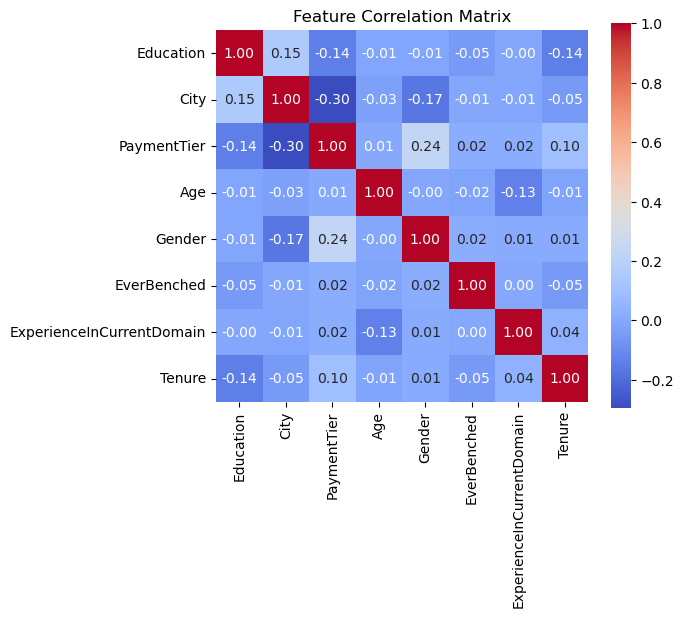

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.show()


In [115]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# 수치형만 추출 (VIF는 수치형만 사용 가능)
X_numeric = X.select_dtypes(include=[np.number])

# VIF 계산
vif_data = pd.DataFrame()
vif_data['feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i)
                   for i in range(X_numeric.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)


,feature,VIF
3,Age,12.682726
2,PaymentTier,9.895627
6,ExperienceInCurrentDomain,4.062657
7,Tenure,3.468585
4,Gender,2.637134
1,City,1.973037
0,Education,1.308967
5,EverBenched,1.117721


흠.. 그렇다고 Age랑 PaymentTier를 삭제해봐도 성능이 크게 나아지지 않았어요... ㅠㅠ

## 2-3. 스케일링

In [117]:
# 스케일링
from sklearn.preprocessing import RobustScaler

#scaler = RobustScaler()
#X['Age'] = scaler.fit_transform(X[['Age']])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Age 같은 경우 plot 찍어봤을 떄 왼쪽으로 치우친 분포를 보여서,
StandardScaler말고 RobustScaler를 써볼까 했는데,
성능이 나아지지 않았어요....

## 2-4. 훈련용/테스트용 데이터 분할

In [160]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y, 
    random_state=SEED
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3489, 8)
(3489,)
(1164, 8)
(1164,)


# 3. 모델링 (1)

In [119]:
# 모델을 불러와 훈련시킵니다.
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [120]:
# 모델을 통해 예측을 수행합니다.
y_lr_pred = lr.predict(X_test)

In [121]:
# 계산된 예측값에 대해 정확도를 계산합니다.
lr_accuracy = accuracy_score(y_test, y_lr_pred)
lr_report = classification_report(y_test, y_lr_pred)

print(f"Accuracy score : {lr_accuracy}")
print(f"Report :\n{lr_report}")

Accuracy score : 0.7242268041237113
Report :
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       775
           1       0.64      0.40      0.49       389

    accuracy                           0.72      1164
   macro avg       0.69      0.64      0.65      1164
weighted avg       0.71      0.72      0.70      1164



In [122]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [123]:
y_tree_pred = tree.predict(X_test)

In [124]:
tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_report = classification_report(y_test, y_tree_pred)

print(f"Accuracy score : {tree_accuracy}")
print(f"Report :\n{tree_report}")

Accuracy score : 0.8350515463917526
Report :
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       775
           1       0.77      0.72      0.75       389

    accuracy                           0.84      1164
   macro avg       0.82      0.81      0.81      1164
weighted avg       0.83      0.84      0.83      1164



In [125]:
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [126]:
y_svm_pred = svm.predict(X_test)

In [127]:
svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_report = classification_report(y_test, y_svm_pred)

print(f"Accuracy score : {svm_accuracy}")
print(f"Report :\n{svm_report}")

Accuracy score : 0.8548109965635738
Report :
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       775
           1       0.91      0.63      0.74       389

    accuracy                           0.85      1164
   macro avg       0.87      0.80      0.82      1164
weighted avg       0.86      0.85      0.85      1164



In [128]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [129]:
y_knn_pred = knn.predict(X_test)

In [130]:
knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_report = classification_report(y_test, y_knn_pred)

print(f"Accuracy score : {knn_accuracy}")
print(f"Report :\n{knn_report}")

Accuracy score : 0.8298969072164949
Report :
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       775
           1       0.81      0.64      0.71       389

    accuracy                           0.83      1164
   macro avg       0.82      0.78      0.80      1164
weighted avg       0.83      0.83      0.82      1164



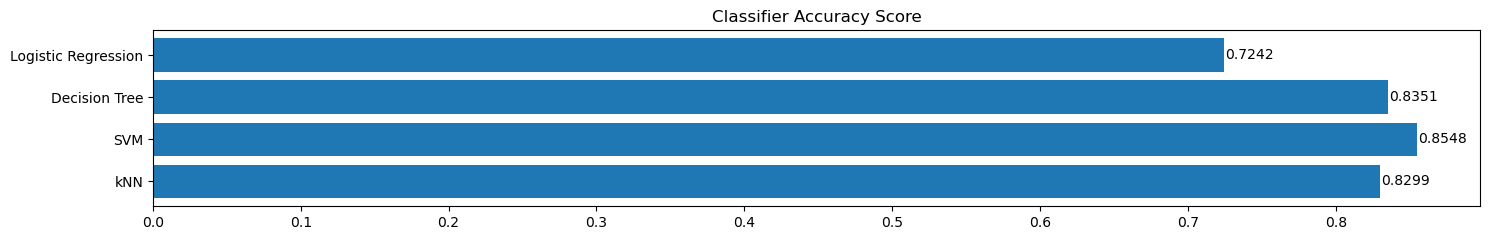

In [131]:
model_name = ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
accuracy_scores = [lr_accuracy, tree_accuracy, svm_accuracy, knn_accuracy]

plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

전처리 전보다 Decision Tree에서 더 안 좋아졌는데 (0.8359 -> 0.8351)
다른 것들은 똑같네요
ㅠㅠ
그래도 저를 믿고 이대로 하겠습니다

# 4. 모델링 (2)

## 4-1. Bagging: RandomForestClassifier

In [134]:
# 모델 생성
rf_clf = RandomForestClassifier(random_state=SEED)

# 모델 훈련
rf_clf.fit(X_train, y_train) 

# 테스트 데이터에 대한 예측 수행
y_rf_pred = rf_clf.predict(X_test)

# 정확도 출력
print(f"Bagging (Random Forest) Accuracy: {accuracy_score(y_test, y_rf_pred):}")

Bagging (Random Forest) Accuracy: 0.8530927835051546


## 4-2. Boosting 

### 4-2-1. AdaBoost

In [135]:
# 모델 생성
adaboost = AdaBoostClassifier(random_state=SEED)

# 모델 훈련
adaboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_ada_pred = adaboost.predict(X_test)

# 정확도 출력
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_ada_pred):}")

AdaBoost Accuracy: 0.8230240549828178


### 4-2-2. GBM

In [152]:
# 모델 생성
gbm = GradientBoostingClassifier(n_estimators=120, learning_rate=0.3, max_depth=3, random_state=SEED)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):}")

GBM Accuracy: 0.8745704467353952


In [159]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 120, 150, 200, 250],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
    'max_depth': [1, 3, 5, 7],
    'subsample': [0.7, 1.0]
}
# 기본 모델 정의
gbm = GradientBoostingClassifier(random_state=42)

# GridSearchCV 정의
grid_search = GridSearchCV(
    estimator=gbm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 학습 실행
grid_search.fit(X_train, y_train)

# 최적 파라미터 및 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# 테스트셋 평가
best_gbm = grid_search.best_estimator_
y_pred_gbm = best_gbm.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_gbm))
print(classification_report(y_test, y_pred_gbm))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best CV Accuracy: 0.846373117700501
Test Accuracy: 0.872852233676976
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       775
           1       0.92      0.68      0.78       389

    accuracy                           0.87      1164
   macro avg       0.89      0.83      0.85      1164
weighted avg       0.88      0.87      0.87      1164



GBM 성능 좋은 편으로 나타남! <br>
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0} <br>
Test Accuracy: 0.872852233676976

### 4-2-3. XGBoost

In [143]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
    'max_depth': [1, 3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# 최적 모델로 테스트셋 평가
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:31:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:31:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:31:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:31:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
Best Cross-Validation Accuracy: 0.848092726502859
Test Accuracy: 0.8797250859106529
              precision    recall  f1-score   support

           0       0.86      0.97      0.92       775
           1       0.93      0.69      0.79       389

    accuracy                           0.88      1164
   macro avg       0.90      0.83      0.85      1164
weighted avg       0.89      0.88      0.87      1164



/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:31:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:31:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:31:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost 성능 좋은 편으로 나타남! <br>
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7} <br>
Test Accuracy: 0.8797250859106529

### 4-2-4. LGBM

In [158]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# 파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63]  # 트리 복잡도 조절
}

# 모델 정의
lgbm_model = LGBMClassifier(random_state=42, verbose=-1)

# GridSearchCV 정의
grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 학습
grid_search.fit(X_train, y_train)

# 결과 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# 최적 모델로 테스트셋 평가
best_lgbm = grid_search.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Test Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))


Fitting 5 folds for each of 126 candidates, totalling 630 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 15}
Best Cross-Validation Accuracy: 0.8314709376657227
Test Accuracy: 0.8599656357388317
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       775
           1       0.84      0.72      0.77       389

    accuracy                           0.86      1164
   macro avg       0.85      0.83      0.84      1164
weighted avg       0.86      0.86      0.86      1164



### 4-2-5. CatBoost

In [148]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# 파라미터 그리드 설정
param_grid = {
    'iterations': [100, 150, 200, 250, 300],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'depth': [3, 5, 7]
}

# 기본 모델 정의
cb_model = CatBoostClassifier(random_state=42, verbose=0)

# 그리드서치 객체 생성
grid_search = GridSearchCV(
    estimator=cb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 그리드서치 실행
grid_search.fit(X_train, y_train)

# 결과 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# 최적 모델로 테스트셋 평가
best_cb = grid_search.best_estimator_
y_pred_cb = best_cb.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Test Accuracy:", accuracy_score(y_test, y_pred_cb))
print(classification_report(y_test, y_pred_cb))


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'depth': 3, 'iterations': 200, 'learning_rate': 0.1}
Best Cross-Validation Accuracy: 0.8443665648522319
Test Accuracy: 0.8737113402061856
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       775
           1       0.91      0.69      0.78       389

    accuracy                           0.87      1164
   macro avg       0.89      0.83      0.85      1164
weighted avg       0.88      0.87      0.87      1164



CatBoost 성능 좋은 편으로 나타남! <br>
Best Parameters: {'depth': 3, 'iterations': 200, 'learning_rate': 0.1}<br>
Test Accuracy: 0.8737113402061856

# 5. Stacking

In [156]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stack_clf = StackingClassifier(
    estimators=[
        ('gbm', gbm),
        ('xgb', xgboost),
        ('cat', cb_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1
)

# 학습 및 예측
stack_clf.fit(X_train, y_train)
y_stack_pred = stack_clf.predict(X_test)

# 평가
print(f"StackingClassifier Accuracy: {accuracy_score(y_test, y_stack_pred):}")
print(classification_report(y_test, y_stack_pred))


StackingClassifier Accuracy: 0.8823024054982818
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       775
           1       0.90      0.72      0.80       389

    accuracy                           0.88      1164
   macro avg       0.89      0.84      0.86      1164
weighted avg       0.88      0.88      0.88      1164



### 🔍 GBM, XGBoost, CatBoost 기반의 StackingClassifier의 테스트셋 정확도: 88.23%

내가 생각한 대로 전처리를 하면 바로 성능이 좋아질 줄 알았는데, 오히려 성능이 떨어지는 경우가 너무 많아서 조금 답답했다. 
이번 과제를 통해 앙상블에 대한 개념도 잡을 수 있었고, 특히 전처리(피쳐 엔지니어링) 부분을 다시 보게 되어서 굉장히 유익한 과제였다. 
성능이 드라마틱하게 좋아지진 않아서 아쉽다. 1% 올리는 것도 이렇게 어렵구나 깨닫게 되었다.